In [1]:
from Classifier.model import Model #, tfidf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from sklearn import preprocessing
from collections import Counter
import os
from dotenv import load_dotenv
import pandas as pd
import ijson
import pickle
import shap
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy
load_dotenv()

PATH_DRIVE = os.getenv("OUTPUTS_DIR")

In [2]:
def split_data_for_class(model, model_name, _class, k_best_features, Classifier_option):
    
    # split data
    print("model_name: {}".format(model_name))
    if Classifier_option == "binary":
        model.split_corpus_binary(_class, k_best_features)
        is_splited = model.balance_data_Undersample_the_biggest_dataset(_class)
        return is_splited

def get_feature_importances(trained_model, model_name, k_best_features):
    if model_name == "LogisticRegression":
        lst = []
        # get importance
        importance = trained_model.coef_[0]
        
        # summarize feature importance
        for i,v in enumerate(importance):
            lst.append((k_best_features[i],v))
        return lst
    else:
        return list(zip(k_best_features,trained_model.feature_importances_)) 
    
def detach_list(lst):
    new_lst = []
    for a,b in lst:
        new_lst.append(max(a,b))
    return new_lst

def print_miss(y_predict_test, df_test):
    test_jump = 66241+18926
    miss_lst = []
    for i,val in enumerate (y_predict_test):
        if val != model.data.iloc[test_jump+i,:].status:
            miss_lst.append(model.data.index[test_jump+i])
    
        
def run_model(model, _class, Classifier_option, model_name, k_best_features, paths_to_save_data, subreddit_name, dec_tree_params={'max_depth':"--"}):
    
    # train model
    
    k_feature_names.remove('created_date')
    k_feature_names.remove('status')
    print("---------------------- " + _class + " -------------------------")
#     print("k_feature_names {} : {}".format(len(k_feature_names), k_feature_names))
    

    trined_model = model.train_model(model_name=model_name , dec_tree_params=dec_tree_params)
    
    y_predict_train = trined_model.predict(model.df_train)
    y_predict_prob_train = numpy.array(trined_model.predict_proba(model.df_train))[:, 1]
    
   
    y_predict_valid = trined_model.predict(model.df_valid)
    y_predict_prob_vaild =  numpy.array(trined_model.predict_proba(model.df_valid))[:, 1]
   
    y_predict_test = trined_model.predict(model.df_test)
    y_predict_prob_test = numpy.array(trined_model.predict_proba(model.df_test))[:, 1]

        
    # evaluate

    evaluation_res_test, evaluation_res_valid, evaluation_res_train = model.evaluation_indices(y_predict_test, y_predict_prob_test, _class, y_predict_train, y_predict_prob_train, y_predict_valid, y_predict_prob_vaild)
    
    classifier_data = [model_name, Classifier_option, _class]
    
    classifier_data.append(model.get_class_size(model.train_labels)) # model.train_labels
    classifier_data.append(model.get_class_size(model.test_labels)) # model.test_labels
    classifier_data.append(model.get_class_size(model.valid_labels)) # model.valid_labels
    
    if _class != 'all':
        classifier_data.append(len(model.data[model.data['status'] == _class]))
        tn, fp, fn, tp = confusion_matrix(model.test_labels, y_predict_test, labels=["not_"+_class, _class]).ravel()
        print("TN: ", tn, "FP: ", fp, " FN: ", fn, " TP: ", tp)
    else:
        classifier_data.append(len(model.data.index))
             
    features_data = [sorted(get_feature_importances(trined_model, model_name, k_best_features), key=lambda x:x[1], reverse=True), len(k_best_features)]
    model.file_reader.testing_recorder(features_data, evaluation_res_train, evaluation_res_valid, evaluation_res_test, classifier_data, dec_tree_params['max_depth'], paths_to_save_data["write_result_path"])
    
    # saving trained model to disk
    
    # Create the directory 
    try: 
        os.mkdir(paths_to_save_data["save_model_path"]) 
    except OSError as error: 
        print(error)  

    model_file_name = 'k_{}_{}_{}_{}_model.pkl'.format(len(k_feature_names),subreddit_name, model_name, _class)
    if model_name == 'DecisionTreeClassifier':
        model_file_name = 'k_{}_{}_{}_{}_{}_model.pkl'.format(len(k_feature_names),subreddit_name, model_name, dec_tree_params['max_depth'], _class)
    model_file_name = paths_to_save_data["save_model_path"] + model_file_name
    with open(model_file_name, 'wb') as f:
        pickle.dump(trined_model, f)

In [15]:
# DecisionTree hyperparameter optimization using Grid Search
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
def DecisionTree_optimization(model):
    X = model.df_train
    y = model.train_labels
    std_slc = StandardScaler()
    pca = decomposition.PCA()
    dec_tree = tree.DecisionTreeClassifier()
    pipe = Pipeline(steps=[('std_slc', std_slc),
                         ('pca', pca),
                         ('dec_tree', dec_tree)])
    n_components = list(range(1,X.shape[1]+1,1))
    criterion = ['gini', 'entropy']
    max_depth = [dep for dep in range(10,12)]
    parameters = dict(pca__n_components=n_components,
                      dec_tree__criterion=criterion,
                      dec_tree__max_depth=max_depth)

    clf_GS = GridSearchCV(pipe, parameters) 
    clf_GS.fit(X, y)
    
    # Now we are using print statements to print the results. It will give the values of hyperparameters as a result.
    print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])
    return  (clf_GS.best_estimator_.get_params()['dec_tree__criterion'], clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])


In [16]:
def data_preprocissing(model, feature_list):
    columns=model.data.columns
    if 'date' in columns:
        model.data.rename(columns = {'date':'created_date'}, inplace = True)
    if 'author_fullname' in columns:
        model.data.drop(columns=['author_fullname'], inplace = True)
    if 'num_comments' in columns:
        model.data.drop(columns=['num_comments'], inplace = True)
    if 'is_retrieved' in columns:
        print('is_retrieved droped')
        model.data.drop(columns=['is_retrieved'], inplace = True)
    if 'selftext_len' in columns:
        model.data.drop(columns=['selftext_len'], inplace = True)
    if 'title_selftext' in columns:
        model.data.drop(columns=['title_selftext'], inplace = True)
    contdition = ((model.data['status'] != 'deleted')&(model.data['status'] != 'poll')&(model.data['status'] != 'automod_filtered'))
    model.data = model.data[contdition]
    model.data.status.replace(['removed', 'shadow_ban'], 'not_exist', inplace=True)
    model.MAX_POST_NUMBER = model.data.shape[0]
    return feature_list

In [17]:
import numpy as np
def SHAP(model, k_features):
        model.split_corpus_basic()
        y = model.train_labels 
        y.replace(['removed', 'shadow_ban'], 'not_exist', inplace=True)
        model.df_train.drop(columns=['created_date'], inplace=True)
        X = model.df_train*1
        
        #train XGBoost model
        model1 = xgboost.XGBClassifier(max_depth=5, learning_rate=0.5).fit(X, y)

        #compute SHAP values
        explainer = shap.Explainer(model1, X, link=shap.links.logit)
        shap_values = explainer(X)        
        shap.plots.bar(shap_values)
        
        vals = np.abs(shap_values.values).mean(0)
        feature_names = X.columns

        feature_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
        k_featues_name = [f_name for f_name, val in feature_importance.head(k_features).values.tolist()]
        return k_featues_name 

-------------------------------2022-----------------------
-----------------------------antiwork    DONE-----------------------
-----------------------------AskARussian    DONE-----------------------
-----------------------------cryptocurrency    DONE-----------------------
-----------------------------UkrainianConflict    DONE-----------------------
-----------------------------robinhood    DONE-----------------------
-------------------------------2021-----------------------
-----------------------------antiwork    DONE-----------------------
-----------------------------cryptocurrency    DONE-----------------------
-----------------------------trueoffmychest    DONE-----------------------
-----------------------------robinhood    DONE-----------------------
-------------------------------2020-----------------------
-----------------------------antiwork    DONE-----------------------
-----------------------------conservative    DONE-----------------------
----------------------------

 99%|===================| 32830/33204 [00:53<00:00]        

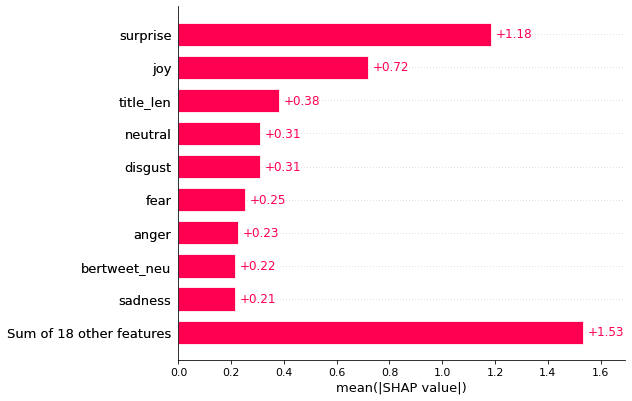

model_name: DecisionTreeClassifier
class_name exist
((29053, 7), (29053,))
((8301, 7), (8301,))
((4151, 7), (4151,))

DecisionTreeClassifier(max_depth=10)
---------------------- exist -------------------------
---TRAIN---
Accuracy: 84.43%
precision: 85.09% 
recall: 84.43% 
fscore: 84.35% 
AUC 90.6025%
---VALID---
Accuracy: 79.47%
precision: 80.29% 
recall: 79.47% 
fscore: 79.33% 
AUC 81.7112%
---TEST---
Accuracy: 82.82%
precision: 83.33% 
recall: 82.82% 
fscore: 82.75% 
AUC 85.4651%
TN:  1470 FP:  448  FN:  211  TP:  1707
classifier_data:  [76, '06/23/2022', '18:58:33', 10, 'DecisionTreeClassifier', 'binary', 'exist', [('not_exist', 8293), ('exist', 8293)], [('not_exist', 1918), ('exist', 1918)], [('exist', 4052), ('not_exist', 4052)], 27242, [('neutral', 0.3887888399743343), ('surprise', 0.2341930267998869), ('fear', 0.1242426524789408), ('joy', 0.10850458878179615), ('title_len', 0.10238207804712415), ('disgust', 0.04188881391791776)], 6, 0.8442662486434342, 0.8508615303726615, 0.844

In [18]:
models_name = ['DecisionTreeClassifier', "RandomForestClassifier", "XGBClassifier"] #, 'LogisticRegression']

# without deleted class

classes = ['exist'] 

# Insert the directory path in here
path_to_classifier_data_folder = r'/sise/home/shai1/combain_classifier_output/' 


l_year_folders = os.listdir(path_to_classifier_data_folder)
file_set = set()

feature_list = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise', 'bertweet_neg', 
                'bertweet_neu', 'bertweet_pos', 'hate', 'offensive', 'title_len', 'title_hashtag',
                'title_exclamation_mark', 'title_dot', 'title_asterisk', 'selftext_hashtag', 
                'selftext_exclamation_mark', 'selftext_dot', 'selftext_asterisk', 'is_video', 'contain_URL', 
                'is_profane', 'contain_question', 'detect_english', 'author_cumcount'] 

already_done=["antiwork","conservative", 'israel', 'politics', 'palestine', 'cryptocurrency', 'mensrights',
              'stocks', 'technology']

for year in l_year_folders:
    print("-------------------------------{}-----------------------".format(year))
    for file_name in os.listdir(path_to_classifier_data_folder + year):
        subreddit = file_name.split("_")[0]
        file_set.add(file_name)
        if year != "2020":
            print("-----------------------------{}    DONE-----------------------".format(file_name))
            continue
        if year =="2020" and subreddit != 'stocks': 
            print("-----------------------------{}    DONE-----------------------".format(file_name))
            continue            
        print("-----------------------------{}-----------------------".format(file_name))
        subreddiit_path_to_write_analysis = path_to_classifier_data_folder + '{}/{}/combine_classifier_{}_post_{}.csv'.format(year, subreddit, subreddit, year) # folder, file
        model = Model(year=year, subreddit=subreddit, sub_kind='post')
#         model_2022 = Model(year='2022', subreddit=subreddit, sub_kind='post')
#         data = [model.data ,model_2022.data]
#         model.data = pd.concat(data)
        feature_list = data_preprocissing(model, feature_list)
        k_features = 6
        k_feature_names = SHAP(model, k_features)
        
        for _class in classes:
            for model_name in models_name:
                is_splited = split_data_for_class(model, model_name, _class, k_feature_names, "binary")
                if is_splited == False: 
                    print("subreddit", file_name, "  status", model.data.status.value_counts())
                    break
                paths={'write_result_path': subreddiit_path_to_write_analysis, 'save_model_path': path_to_classifier_data_folder + '{}/{}/models_combine/'.format(year, subreddit, file_name)}
                if model_name == 'DecisionTreeClassifier':
                    criterion ,max_depth = DecisionTree_optimization(model)
                    dec_tree_params = {"criterion": criterion, "max_depth":max_depth}
                    run_model(model, _class, "binary", model_name, k_feature_names, paths, subreddit, dec_tree_params)
                else:
                    run_model(model, _class, "binary", model_name, k_feature_names, paths, subreddit)
            model.data = model.read_dataset(year=year, subreddit=subreddit, sub_kind='post')
            feature_list = data_preprocissing(model, feature_list)

In [7]:
year="2020"
sub_kind="post"
subreddit = "stocks"
pd.read_pickle(f"/dt/puzis/dt-reddit/cleaned_data/{subreddit}_{sub_kind}_{year}.pickle")

,title_selftext,date,status,retrieved,author_fullname,link_flair_text,num_comments
post_id,,,,,,,
i2vudh,thoughts about investing in madison square gar...,"['2020-08-03', '15:06:08']",deleted,False,t2_6c4xiskb,None,1
kkw7xz,does anyone use motley fool here i signed up f...,"['2020-12-27', '05:26:14']",deleted,True,t2_38omgh87,None,17
i2vpdd,faang stocks with most room to grow i m in the...,"['2020-08-03', '14:55:57']",exist,True,t2_1538dr,Discussion,41
kkw7h3,help this baby my first stocks portfolio brand...,"['2020-12-27', '05:25:20']",deleted,True,t2_6c6og5lw,None,16
i2vong,top stock for august,"['2020-08-03', '14:54:26']",removed,False,t2_3m7c4pqd,None,0
...,...,...,...,...,...,...,...
i2w52k,trump threatens a shutdown of tiktok unless ms...,"['2020-08-03', '15:27:30']",exist,True,t2_dyc5p,Discussion,10
kkwlty,gig economy stocks or etfs i have been really ...,"['2020-12-27', '05:52:36']",exist,True,t2_uh5b9ly,Advice Request,4
i2w22s,question opinions on investing in madison squa...,"['2020-08-03', '15:21:30']",deleted,True,t2_6c4xiskb,None,3


# Word Embedding - Classifier

In [ ]:
def create_embedding_df(df):
    basic_data_df = df[['post_id', 'created_date', 'status', 'Topic', 'Name', 'topic_words', 'title_selftext']]
    basic_data_df = basic_data_df[basic_data_df['title_selftext'].apply(lambda x: type(x) == str)]
    documents = [TaggedDocument(row['title_selftext'], [row['post_id']]) for index, row in basic_data_df.iterrows()]
    model = Doc2Vec(documents, vector_size=300, window=2, min_count=1, workers=4)
    vec_lst = []
    post_id_lst = []
    for index, row in basic_data_df.iterrows():
        post_id_lst.append(row['post_id'])
        vec_lst.append(model.docvecs[row['post_id']].tolist())
    emdedding_df = pd.DataFrame(data=vec_lst)
    emdedding_df['post_id']=post_id_lst
    ans_df = pd.merge(basic_data_df, emdedding_df, on="post_id")
    ans_df.drop(['post_id','Topic', 'Name', 'topic_words', 'title_selftext'], axis=1, inplace=True)
    return ans_df

# Exec Code

In [7]:
models_name = ['DecisionTreeClassifier', "RandomForestClassifier", "XGBClassifier"]

# without deleted class

classes = ['exist'] 

# Insert the directory path in here
path_to_classifier_data_folder = r'/dt/puzis/dt-reddit/feature_embedding/' 


l_year_folders = os.listdir(path_to_classifier_data_folder)
file_set = set()

already_done=["antiwork"]

for year in l_year_folders:
    print("-------------------------------{}-----------------------".format(year))
    for file_name in os.listdir(path_to_classifier_data_folder + year):
        subreddit = file_name.split("_")[0]
        file_set.add(file_name)
        if year != "2022":
            print("-----------------------------{}    DONE-----------------------".format(file_name))
            continue
#         if year =="2022" and subreddit in already_done: # Cryptocurrency LateStageCapitalism
#             print("-----------------------------{}    DONE-----------------------".format(file_name))
#             continue            
        print("-----------------------------{}-----------------------".format(file_name))
        subreddiit_path_to_write_analysis = path_to_classifier_data_folder + '{}/{}/embedding_classifier_{}_post_{}.csv'.format(year, subreddit, subreddit, year) # folder, file
        model = Model(year=year, subreddit=subreddit, sub_kind='post')
#         model_2022 = Model(year='2022', subreddit=subreddit, sub_kind='post')
#         data = [model.data ,model_2022.data]
#         model.data = pd.concat(data)
        feature_list = model.data.columns.tolist()
        feature_list = data_preprocissing(model, feature_list)
        k_features = 6
        k_feature_names = model.data.columns.tolist()
        
        for _class in classes:
            for model_name in models_name:
                is_splited = split_data_for_class(model, model_name, _class, k_feature_names, "binary")
                print("is_splited", is_splited)
                if is_splited == False: 
                    print("subreddit", file_name, "  status", model.data.status.value_counts())
                    break
                paths={'write_result_path': subreddiit_path_to_write_analysis, 'save_model_path': path_to_classifier_data_folder + '{}/{}/models_combine/'.format(year, subreddit, file_name)}
                if model_name == 'DecisionTreeClassifier':
                    print("here")
#                     criterion ,max_depth = DecisionTree_optimization(model)
                    dec_tree_params = {"criterion": 'gini', "max_depth":5}
                    print("dec_tree_params", dec_tree_params)
                    run_model(model, _class, "binary", model_name, k_feature_names, paths, subreddit, dec_tree_params)
                else:
                    run_model(model, _class, "binary", model_name, k_feature_names, paths, subreddit)
            model.data = model.read_dataset(year=year, subreddit=subreddit, sub_kind='post')
            feature_list = data_preprocissing(model, feature_list)

-------------------------------2020-----------------------
-----------------------------antiwork    DONE-----------------------
-----------------------------conservative    DONE-----------------------
-----------------------------cryptocurrency    DONE-----------------------
-----------------------------israel    DONE-----------------------
-----------------------------mensrights    DONE-----------------------
-----------------------------palestine    DONE-----------------------
-----------------------------politics    DONE-----------------------
-----------------------------stocks    DONE-----------------------
-----------------------------technology    DONE-----------------------
-----------------------------wallstreetbets    DONE-----------------------
-----------------------------robinhood    DONE-----------------------
-------------------------------2021-----------------------
-----------------------------antiwork    DONE-----------------------
-----------------------------cryptoc

Version 7.4.0 of praw is outdated. Version 7.6.0 was released Tuesday May 10, 2022.


model_name: DecisionTreeClassifier
class_name exist
((66661, 385), (66661,))
((19046, 385), (19046,))
((9523, 385), (9523,))
is_splited None
here
dec_tree_params {'criterion': 'gini', 'max_depth': 5}
---------------------- exist -------------------------
---TRAIN---
Accuracy: 65.84%
precision: 65.86% 
recall: 65.84% 
fscore: 65.83% 
AUC 70.9780%
---VALID---
Accuracy: 64.72%
precision: 64.78% 
recall: 64.72% 
fscore: 64.68% 
AUC 70.4404%
---TEST---
Accuracy: 63.85%
precision: 63.87% 
recall: 63.85% 
fscore: 63.84% 
AUC 68.6348%
TN:  1810 FP:  1114  FN:  1000  TP:  1924
classifier_data:  [19, '06/09/2022', '08:16:36', 5, 'DecisionTreeClassifier', 'binary', 'exist', [('not_exist', 28638), ('exist', 28638)], [('not_exist', 2924), ('exist', 2924)], [('exist', 5229), ('not_exist', 5229)], 58439, [(99, 0.38649112413596803), (227, 0.1755777321371583), (251, 0.12670325210694638), (304, 0.07074037290531851), (221, 0.04261056261393632), (189, 0.03934038493757999), (92, 0.023606368360740423), (106

((66661, 385), (66661,))
((19046, 385), (19046,))
((9523, 385), (9523,))
is_splited None
---------------------- exist -------------------------
[08:17:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.65820	validation_1-logloss:0.66360
[1]	validation_0-logloss:0.63550	validation_1-logloss:0.64460
[2]	validation_0-logloss:0.61977	validation_1-logloss:0.63341
[3]	validation_0-logloss:0.60806	validation_1-logloss:0.62560
[4]	validation_0-logloss:0.59879	validation_1-logloss:0.61984
[5]	validation_0-logloss:0.59097	validation_1-logloss:0.61630
[6]	validation_0-logloss:0.58488	validation_1-logloss:0.61314
[7]	validation_0-logloss:0.57918	validation_1-logloss:0.61053
[8]	validation_0-logloss:0.57461	validation_1-logloss:0.60857
[9]	validation_0-logloss:0.57034	validation_1-

-----------------------------AskARussian-----------------------
model_name: DecisionTreeClassifier
class_name exist
((4370, 385), (4370,))
((1248, 385), (1248,))
((626, 385), (626,))
is_splited None
here
dec_tree_params {'criterion': 'gini', 'max_depth': 5}
---------------------- exist -------------------------
---TRAIN---
Accuracy: 78.48%
precision: 78.65% 
recall: 78.48% 
fscore: 78.45% 
AUC 86.9659%
---VALID---
Accuracy: 56.47%
precision: 56.52% 
recall: 56.47% 
fscore: 56.39% 
AUC 58.8185%
---TEST---
Accuracy: 52.72%
precision: 52.74% 
recall: 52.72% 
fscore: 52.65% 
AUC 55.8945%
TN:  135 FP:  104  FN:  122  TP:  117
classifier_data:  [1, '06/09/2022', '08:20:44', 5, 'DecisionTreeClassifier', 'binary', 'exist', [('not_exist', 474), ('exist', 474)], [('exist', 239), ('not_exist', 239)], [('exist', 363), ('not_exist', 363)], 5168, [(382, 0.10023683403827367), (268, 0.08334338801551908), (98, 0.06173654260699455), (367, 0.04686913484881941), (258, 0.046215031279681754), (14, 0.0459984

is_splited None
---------------------- exist -------------------------
[08:20:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.59553	validation_1-logloss:0.69345
[1]	validation_0-logloss:0.52257	validation_1-logloss:0.68312
[2]	validation_0-logloss:0.46172	validation_1-logloss:0.68920
[3]	validation_0-logloss:0.41078	validation_1-logloss:0.68792
[4]	validation_0-logloss:0.37009	validation_1-logloss:0.68525
[5]	validation_0-logloss:0.34777	validation_1-logloss:0.69307
[6]	validation_0-logloss:0.32647	validation_1-logloss:0.69709
[7]	validation_0-logloss:0.29381	validation_1-logloss:0.69643
[8]	validation_0-logloss:0.27306	validation_1-logloss:0.69120
[9]	validation_0-logloss:0.25128	validation_1-logloss:0.69307
[10]	validation_0-logloss:0.22229	validation_1-logloss:0.

---TRAIN---
Accuracy: 66.42%
precision: 68.08% 
recall: 66.42% 
fscore: 65.62% 
AUC 71.5373%
---VALID---
Accuracy: 61.81%
precision: 62.61% 
recall: 61.81% 
fscore: 61.20% 
AUC 66.0739%
---TEST---
Accuracy: 65.34%
precision: 66.04% 
recall: 65.34% 
fscore: 64.96% 
AUC 69.2893%
TN:  766 FP:  629  FN:  338  TP:  1057
classifier_data:  [1, '06/09/2022', '08:24:28', 5, 'DecisionTreeClassifier', 'binary', 'exist', [('exist', 13780), ('not_exist', 13780)], [('exist', 1395), ('not_exist', 1395)], [('not_exist', 4250), ('exist', 4250)], 19425, [(157, 0.4870414861249479), (294, 0.12010611904287083), (99, 0.1026613387465569), (278, 0.08963209460420161), (233, 0.039885974157529085), (6, 0.02556656834645002), (367, 0.0245958444054303), (127, 0.021146765843123173), (259, 0.014315557655266318), (191, 0.01191264510554013), (224, 0.009173099408101692), (54, 0.008829776859456939), (126, 0.007672415716559255), (62, 0.007448495251016379), (314, 0.0057233656695995), (377, 0.004110480708808235), (82, 0.004

[Errno 17] File exists: '/dt/puzis/dt-reddit/feature_embedding/2022/cryptocurrency/models_combine/'
model_name: XGBClassifier
class_name exist
((34183, 385), (34183,))
((9766, 385), (9766,))
((4884, 385), (4884,))
is_splited None
---------------------- exist -------------------------
[08:24:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.65235	validation_1-logloss:0.66114
[1]	validation_0-logloss:0.62499	validation_1-logloss:0.64222
[2]	validation_0-logloss:0.60555	validation_1-logloss:0.62836
[3]	validation_0-logloss:0.59029	validation_1-logloss:0.61787
[4]	validation_0-logloss:0.57873	validation_1-logloss:0.60895
[5]	validation_0-logloss:0.56813	validation_1-logloss:0.60150
[6]	validation_0-logloss:0.55809	validation_1-logloss:0.59579
[7]	validation_0-logloss:0.55

-----------------------------UkrainianConflict-----------------------
model_name: DecisionTreeClassifier
class_name exist
((19108, 385), (19108,))
((5459, 385), (5459,))
((2731, 385), (2731,))
is_splited None
here
dec_tree_params {'criterion': 'gini', 'max_depth': 5}
---------------------- exist -------------------------
---TRAIN---
Accuracy: 65.48%
precision: 66.56% 
recall: 65.48% 
fscore: 64.90% 
AUC 69.8345%
---VALID---
Accuracy: 61.97%
precision: 62.77% 
recall: 61.97% 
fscore: 61.37% 
AUC 65.0346%
---TEST---
Accuracy: 59.40%
precision: 60.86% 
recall: 59.40% 
fscore: 57.99% 
AUC 62.9419%
TN:  177 FP:  254  FN:  96  TP:  335
classifier_data:  [1, '06/09/2022', '08:29:04', 5, 'DecisionTreeClassifier', 'binary', 'exist', [('exist', 5353), ('not_exist', 5353)], [('not_exist', 431), ('exist', 431)], [('exist', 1182), ('not_exist', 1182)], 20332, [(99, 0.2521901322671957), (134, 0.10838015768151506), (135, 0.08440302795402282), (125, 0.06517921069110032), (177, 0.06060190463430212), (3

is_splited None
---------------------- exist -------------------------
[08:29:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.65957	validation_1-logloss:0.67541
[1]	validation_0-logloss:0.63580	validation_1-logloss:0.66295
[2]	validation_0-logloss:0.61793	validation_1-logloss:0.65377
[3]	validation_0-logloss:0.60109	validation_1-logloss:0.65095
[4]	validation_0-logloss:0.58546	validation_1-logloss:0.65045
[5]	validation_0-logloss:0.57476	validation_1-logloss:0.64839
[6]	validation_0-logloss:0.56589	validation_1-logloss:0.64782
[7]	validation_0-logloss:0.55396	validation_1-logloss:0.64923
[8]	validation_0-logloss:0.54855	validation_1-logloss:0.65087
[9]	validation_0-logloss:0.53717	validation_1-logloss:0.64594
[10]	validation_0-logloss:0.52752	validation_1-logloss:0.

-----------------------------robinhood-----------------------
model_name: DecisionTreeClassifier
class_name exist
((1696, 385), (1696,))
((484, 385), (484,))
((243, 385), (243,))
is_splited None
here
dec_tree_params {'criterion': 'gini', 'max_depth': 5}
---------------------- exist -------------------------
---TRAIN---
Accuracy: 93.37%
precision: 93.89% 
recall: 93.37% 
fscore: 93.35% 
AUC 95.6089%
---VALID---
Accuracy: 61.61%
precision: 61.70% 
recall: 61.61% 
fscore: 61.53% 
AUC 64.2060%
---TEST---
Accuracy: 51.56%
precision: 51.70% 
recall: 51.56% 
fscore: 50.59% 
AUC 56.6406%
TN:  21 FP:  11  FN:  20  TP:  12
classifier_data:  [1, '06/09/2022', '08:29:38', 5, 'DecisionTreeClassifier', 'binary', 'exist', [('exist', 166), ('not_exist', 166)], [('exist', 32), ('not_exist', 32)], [('not_exist', 56), ('exist', 56)], 254, [(250, 0.30467145739434587), (73, 0.0754071113580535), (239, 0.06971618951875501), (204, 0.06266896980082814), (124, 0.05564644359445078), (78, 0.053268107365376204), (

is_splited None
---------------------- exist -------------------------
[08:29:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.52863	validation_1-logloss:0.68895
[1]	validation_0-logloss:0.42136	validation_1-logloss:0.70165
[2]	validation_0-logloss:0.35024	validation_1-logloss:0.66015
[3]	validation_0-logloss:0.28661	validation_1-logloss:0.63689
[4]	validation_0-logloss:0.23309	validation_1-logloss:0.59840
[5]	validation_0-logloss:0.19310	validation_1-logloss:0.59820
[6]	validation_0-logloss:0.16049	validation_1-logloss:0.57195
[7]	validation_0-logloss:0.14018	validation_1-logloss:0.55800
[8]	validation_0-logloss:0.12127	validation_1-logloss:0.55722
[9]	validation_0-logloss:0.10731	validation_1-logloss:0.56663
[10]	validation_0-logloss:0.09692	validation_1-logloss:0.

In [22]:
# import shutil
# # path_to_classifier_data_features_folder = r'/sise/home/shai1/reddit_code_shai/NLP_features/'
# path_to_classifier_data_folder = r'/sise/home/shai1/reddit_code_shai/simple_classifier_by_subreddit/'
# # Insert the directory path in here
 
# # subreddiit_path_to_write_analysis = path_to_classifier_data_folder + '{}/{}/classifier_{}'.format(year, subreddit, file_name) # folder, file
# # subreddiit_path_to_read_analysis = path_to_classifier_data_features_folder + '{}/{}'.format(year,file_name) # folder, file

# # Extracting all the contents in the directory corresponding to path
# l_year_folders = os.listdir(path_to_classifier_data_folder)
# file_set = set()
# for year in l_year_folders:
#     if year in ["2020", "2021", "2022"]:
#         for folder_name in os.listdir(path_to_classifier_data_folder + year):
# #             if year == "2021" and folder_name == "antiwork":
# #                 continue
# #             print(path_to_classifier_data_folder + year+"/"+folder_name)
#             original = r'/sise/home/shai1/reddit_code_shai/simple_classifier_by_subreddit/classifier_test.csv'
#             target = r'/dt/puzis/dt-reddit/feature_embedding/{}/{}/embedding_classifier_{}_post_{}.csv'.format(year, folder_name,folder_name,year) 
# #             original  = r'/sise/home/shai1/reddit_code_shai/simple_classifier_by_subreddit/{}/{}/simple_classifier_{}_post_{}_r2.csv'.format(year, folder_name,folder_name,year)
# #             target = r'/sise/home/shai1/reddit_code_shai/simple_classifier_by_subreddit/simple_featuers_xl_models_r2/simple_classifier_{}_post_{}.csv'.format(folder_name,year)
#             print(target)
#             shutil.copyfile(original, target)
# #             print(folder_name.split("_")[0])
# # #             name = folder_name
# #             print('/dt/puzis/dt-reddit/feature_embedding/' + year+"/"+folder_name)
#             #Create the directory 
# #             try: 
# #                 os.mkdir('/dt/puzis/dt-reddit/feature_embedding/' + year+"/"+folder_name) #'/{}'.format("models")
# #             except OSError as error: 
# #                 print(error)

/dt/puzis/dt-reddit/feature_embedding/2020/antiwork/embedding_classifier_antiwork_post_2020.csv
/dt/puzis/dt-reddit/feature_embedding/2020/conservative/embedding_classifier_conservative_post_2020.csv
/dt/puzis/dt-reddit/feature_embedding/2020/cryptocurrency/embedding_classifier_cryptocurrency_post_2020.csv
/dt/puzis/dt-reddit/feature_embedding/2020/israel/embedding_classifier_israel_post_2020.csv
/dt/puzis/dt-reddit/feature_embedding/2020/mensrights/embedding_classifier_mensrights_post_2020.csv
/dt/puzis/dt-reddit/feature_embedding/2020/palestine/embedding_classifier_palestine_post_2020.csv
/dt/puzis/dt-reddit/feature_embedding/2020/politics/embedding_classifier_politics_post_2020.csv
/dt/puzis/dt-reddit/feature_embedding/2020/stocks/embedding_classifier_stocks_post_2020.csv
/dt/puzis/dt-reddit/feature_embedding/2020/technology/embedding_classifier_technology_post_2020.csv
/dt/puzis/dt-reddit/feature_embedding/2020/wallstreetbets/embedding_classifier_wallstreetbets_post_2020.csv
/dt/pu